In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

In [2]:
import pandas as pd
from IPython.display import HTML
def printmd(string):
    from IPython.display import Markdown, display
    display(Markdown(string))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### postgresql + python ###
import psycopg2 as pg2

class psql_py:
    def __init__(self):
        self.conn = self.connect_db()
        self.cur = self.conn.cursor()
        self.cur.execute("set search_path = mimiciii;") 
        
    def connect_db(self):
        try:
            conn = pg2.connect("host = localhost dbname=mimic user=postgres port=5432")
            #print('database connected')
            return conn
        except:
            print("I am unable to connect to the database")          
            
    def exe_sql (self, exe_sql_str):
        return pd.read_sql(exe_sql_str,self.conn)
    
    def db_query(self, exe_sql_str, mode='sql'):
        if mode == 'pd':
            return_pd = self.exe_sql (exe_sql_str)
            self.close_db()
            return return_pd
        else: 
            self.cur.execute(exe_sql_str)
            self.close_db()
            
    def close_db (self):
        self.cur.close()
        # commit the changes
        self.conn.commit()
        #print('database disconnected')


In [3]:
db = psql_py() 
db.cur.execute(open('./sql/ventilation-durations_mod.sql','r').read())
print('execution complete: ventilation-durations_mod.sql')
db.cur.execute(open('./sql/ventduration_on_off_time.sql','r').read())
print('execution complete: ventduration_on_off_time.sql')
db.cur.execute(open('./sql/ptsinfo_vent.sql','r').read())
print('execution complete: ptsinfo_vent.sql')

str_sql = 'select * from ventdurations'
temp = db.db_query(str_sql,'pd')
total = len(temp.icustay_id.unique())
printmd('## Population using a ventilation extracted by [code](https://github.com/yyjo0430/mimiciii_extubation/tree/master/sql/ventilation-durations_mod.sql): '
        + str(total)+ ' patients \n'+
        '- ### Based on [mimic-code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/durations/ventilation-durations.sql) \n' )




execution complete: ventilation-durations_mod.sql
execution complete: ventduration_on_off_time.sql
execution complete: ptsinfo_vent.sql


## Population using a ventilation extracted by [code](https://github.com/yyjo0430/mimiciii_extubation/tree/master/sql/ventilation-durations_mod.sql): 26801 patients 
- ### Based on [mimic-code](https://github.com/MIT-LCP/mimic-code/blob/master/concepts/durations/ventilation-durations.sql) 


In [4]:
db = psql_py() 
str_sql = 'select * from ptsinfo_vent'
case_missing = db.db_query(str_sql,'pd')
case_missing = case_missing.sort_values(['icustay_id','ventnum','vent_on_time','vent_off_time']).reset_index(drop=True)
case_missing = case_missing.dropna(subset=['icustay_id'])
case_missing.icustay_id = case_missing.icustay_id.astype(int)
num_case_missing = len(case_missing.icustay_id.unique())

printmd('### Exclusion 1 - Population: '+str(num_case_missing) + ', excluded '+ str(total-num_case_missing)+' patients \n' +
'- Excluded patient with records with missing values in variables such as extubation, self-extubation, oxygentherapy, and so on'      
)
display(case_missing.sample(5))


### Exclusion 1 - Population: 23518, excluded 3283 patients 
- Excluded patient with records with missing values in variables such as extubation, self-extubation, oxygentherapy, and so on

,icustay_id,hadm_id,subject_id,gender,birth_time,extu_age,admittime,ventnum,vent_on_time,vent_off_time,duration_hours,unplanned,tra_used,trache_time,dischtime,death_time,death
4583,213875,198791,6241,F,2090-09-11,87.01,2177-09-16 22:44:00,1,2177-09-16 23:00:00,2177-09-27 02:00:00,243.000000,0,1,2177-09-25 15:20:00,2177-09-30 13:47:00,2177-11-06,0
15487,246842,181561,40239,F,2027-09-08,80.83,2108-07-06 07:15:00,1,2108-07-06 11:30:00,2108-07-06 16:18:00,4.800000,0,0,NaT,2108-07-10 12:58:00,NaT,0
16835,250857,125598,26895,F,2109-09-08,75.61,2185-04-06 19:33:00,1,2185-04-17 13:30:00,2185-04-18 12:45:00,23.250000,0,0,NaT,2185-05-25 14:30:00,2185-05-28,0
6548,219545,112575,78241,M,2084-07-29,65.82,2150-05-23 16:18:00,1,2150-05-24 06:00:00,2150-05-24 06:14:00,0.233333,0,0,NaT,2150-05-24 14:45:00,2150-05-24,1
28063,284432,146687,7781,M,2030-05-02,72.60,2102-12-04 14:00:00,1,2102-12-06 18:21:00,2102-12-08 10:00:00,39.650000,0,0,NaT,2103-01-01 18:05:00,2104-08-19,0


In [5]:
case_adult = case_missing.copy()
case_adult = case_adult[(case_adult.extu_age>15 )& (case_adult.extu_age<90)].sort_values('icustay_id')
num_case_adult = len(case_adult.icustay_id.unique())
printmd('### Exclusion 2 - Population: '+ str(num_case_adult) + ', excluded '+str(num_case_missing-num_case_adult)+' patients '+ '\n' +
'- Only adult: >15 & <89  \n'
)



### Exclusion 2 - Population: 21783, excluded 1735 patients 
- Only adult: >15 & <89  


In [6]:
case_unplan = case_adult.copy()
case_unplan = case_unplan[case_unplan.unplanned==0]
num_case_unplan = len(case_unplan.icustay_id.unique())

printmd('### Exclusion 3 - Population: '+ str(num_case_unplan) + ', excluded '+str(num_case_adult-num_case_unplan)+'  patients \n' + 
'- Excluded the unplanned extubation cases')


### Exclusion 3 - Population: 21585, excluded 198  patients 
- Excluded the unplanned extubation cases

In [7]:
case_tra = case_unplan.copy()
case_tra = case_tra[case_tra.tra_used==0]
num_case_tra = len(case_tra.icustay_id.unique())

printmd('### Exclusion 4 - Population: '+ str(num_case_tra) + ', excluded '+str(num_case_unplan-num_case_tra)+' patients \n' +
'- Excluded patient using the tracheostomy')



### Exclusion 4 - Population: 21391, excluded 194 patients 
- Excluded patient using the tracheostomy

In [8]:
case_death = case_tra.copy()
case_death = case_death[case_death.death==0]
num_case_death = len(case_death.icustay_id.unique())
printmd('### Exclusion 5 - Population: '+ str(num_case_death) + ', excluded '+str(num_case_tra-num_case_death)+' patients \n' +
'- Excluded the dead'    
)


### Exclusion 5 - Population: 20692, excluded 699 patients 
- Excluded the dead

In [9]:
case_period = case_death.copy()
case_period = case_period[(case_period.duration_hours>1)]
num_case_period = len(case_period.icustay_id.unique())
printmd('### Exclusion 6 - Population: '+ str(num_case_period) + ', excluded '+str(num_case_death-num_case_period)+' patients\n' +
'- Excluded patients with short period (<1 hour) for the use of the mechanical ventilation'    
)


### Exclusion 6 - Population: 20038, excluded 654 patients
- Excluded patients with short period (<1 hour) for the use of the mechanical ventilation

In [10]:
case_ventnum = case_period.groupby('icustay_id').filter(lambda x:x['ventnum'].min()==1)
num_case_ventnum = len(case_ventnum.icustay_id.unique())
printmd('### Exclusion 7 - Population: '+ str(num_case_ventnum) + ', excluded '+str(num_case_period-num_case_ventnum)+' patients \n' +
        '- Excluded patients where the starting ventnum is 1 \n'+
        '\t - The ventilation number (*ventnum*) means the sequence number of use of the mechanical ventilation \n' +    
        '\t\t - The use of the single mechanical ventilation is defined as a set of records where the interval time between adjacent two records is not over 8 hours'
)


### Exclusion 7 - Population: 19015, excluded 1023 patients 
- Excluded patients where the starting ventnum is 1 
	 - The ventilation number (*ventnum*) means the sequence number of use of the mechanical ventilation 
		 - The use of the single mechanical ventilation is defined as a set of records where the interval time between adjacent two records is not over 8 hours

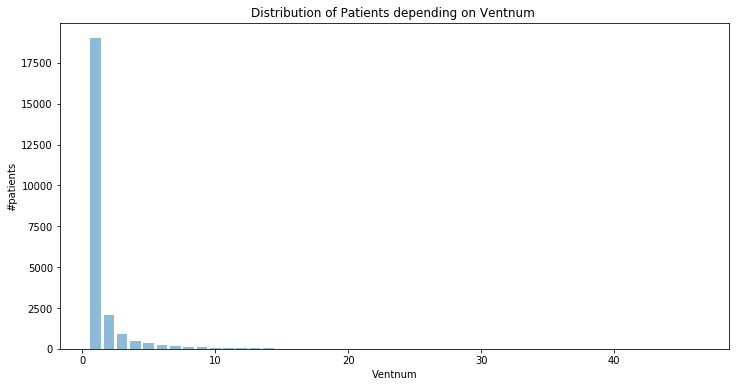

In [11]:
import matplotlib.pyplot as plt
a =case_ventnum.ventnum.value_counts().sort_index()
f, ax = plt.subplots(figsize=(12,6))
plt.bar(a.index,a.values,align='center', alpha=0.5)
plt.xlabel('Ventnum')
plt.ylabel('#patients')
plt.title('Distribution of Patients depending on Ventnum ')
plt.show()
